<a href="https://colab.research.google.com/github/GodoyLucas/king_of_rebirth/blob/main/Notebooks/King_of_Rebirth_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de desempenho dos players em função do input no campeonado de Call of Duty Warzone King of Rebirth

# Importanto bibliotecas e dados

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
final = pd.read_csv('https://raw.githubusercontent.com/GodoyLucas/king_of_rebirth/main/Dados/king.csv', sep = ";")
final.head()

,player,input,partida,kills,colocacao
0,HARDTREVS,controle,1,5.0,36.0
1,HARDTREVS,controle,2,5.0,12.0
2,HARDTREVS,controle,3,11.0,1.0
3,HARDTREVS,controle,4,3.0,5.0
4,HARDTREVS,controle,5,8.0,7.0


# Verificando condições gerais dos dados

In [3]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   player     352 non-null    object 
 1   input      352 non-null    object 
 2   partida    352 non-null    int64  
 3   kills      348 non-null    float64
 4   colocacao  348 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 13.9+ KB


É possível verificar que, apesar de 4 registros nulos em 'kills' e 'colocacao', as 8 partidas dos 44 players estão presentes no conjunto de dados. 

Os dados nulos são então substituídos por "0" e o tipo dados dos campos são convertidos para inteiro.

In [4]:
final.fillna(value = {'kills': 0, 'colocacao': 0}, inplace = True)
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   player     352 non-null    object 
 1   input      352 non-null    object 
 2   partida    352 non-null    int64  
 3   kills      352 non-null    float64
 4   colocacao  352 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 13.9+ KB


In [5]:
final = final.astype({'kills': int, 'colocacao': int})
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   player     352 non-null    object
 1   input      352 non-null    object
 2   partida    352 non-null    int64 
 3   kills      352 non-null    int64 
 4   colocacao  352 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 13.9+ KB


# Premissas de análise

- A final do campeonato foi realizada em 8 partidas;
- Das 8 partidas, apenas as 5 melhores foram usadas para a classificação geral do campeonato;
- O estudo contempla todas as partidas;
- O campeonato ocorreu no modo solo, ou seja, 1 pessoa por time, competição individual;
- 44 players participaram. Portanto, as colocações nas partidas vão de 1 a 44, não sendo possível empate;
- Nem todos os players participaram e/ou reportaram os resultados de todas as partidas. Houve caso do player não querer jogar, caso de ser desconectado da partida por motivo adverso e caso de não querer reportar o resultado de uma determinada partida. Os resultados faltantes decorrentes desses casos, resultados nulos ou resultados impossíveis dado o contexto serão estimados com base nos resultados do player nas demais partidas.
- Para que a lógica da planilha utilizada para consolidação dos resultados no dia do campeonato não quebrasse, resultados não reportados foram registrados com colocação 44. Este estudo procura identificar os registros legítimos para tratar os que assim só tenham sido reportados pelo uso da planilha.
  - Regristros com colocação 44 com zero kills só são considerados legítimos caso não haja outro registro nesta mesma colocação na partida;
  - Regristros com colocação 44 com mais de zero kills só são considerados legítimos caso não haja outro registro nesta mesma colocação com kills registradas na mesma partida;

Considerando a impossibilidade de empate em qualquer que seja a colocação, o ideal dos resultados seria não haver mais que um player por colocação em cada umas das partidas. Abaixo é possível observar tal ocorrencia, além da ocorrência da colocação "0":

In [6]:
registros_com_mais_de_um_player_por_colocacao = pd.DataFrame()

for partida in range(1, 9):
  for colocacao in range(0, 45):
    if final.query('partida == @partida  & colocacao == @colocacao').player.count() != 1:
      registros_com_mais_de_um_player_por_colocacao = pd.concat([registros_com_mais_de_um_player_por_colocacao, final.query('partida == @partida  & colocacao == @colocacao')])

registros_com_mais_de_um_player_por_colocacao.groupby(['partida', 'colocacao'])[['player']].count()

player
partida colocacao        
1       44              8
2       44              6
3       28              2
        34              2
        44              6
4       0               2
        6               2
        22              2
        44              3
5       0               2
        3               2
        40              2
        44              2
6       19              2
        44              3
7       44             10
8       0               5
        44              7

# Tratamento dos dados

Descrição do roteiro de tratamento dado as regras do jogo e as condições dos dados:

- Identificar e separar registros da colocação "0"
- Identificar e separar registros com mais de um player por colocação por partida;
- Identificar e separar registros legítimos da colocação "44";
- Consolidar registros legítimos sem  necessidade de tratamento;
- Consolidar registros para tratamento;
- Tratar registros;
- Consolidar dados tratados;

## Identificando e separando registros com colocação "0":

In [7]:
registros_com_colocacao_0 = final.query('colocacao == 0')
registros_com_colocacao_0

,player,input,partida,kills,colocacao
18,iErickziN,controle,3,0,0
83,MAUMAU,controle,4,0,0
119,FINEKSS,mouse,8,0,0
179,CLARA FIERCE,controle,4,0,0
199,BALTAFPS,mouse,8,0,0
236,IGOTEE,mouse,5,0,0
237,IGOTEE,mouse,6,0,0
238,IGOTEE,mouse,7,0,0
239,IGOTEE,mouse,8,0,0
255,SAVIOLI,controle,8,0,0


In [8]:
registros_sem_colocacao_0 = final[final.index.isin(list(set(final.index) - set(registros_com_colocacao_0.index)))]
registros_sem_colocacao_0.sort_values('colocacao')

,player,input,partida,kills,colocacao
24,MAIKI,controle,1,10,1
321,FODOVSKI,mouse,2,16,1
2,HARDTREVS,controle,3,11,1
22,iErickziN,controle,7,18,1
13,VIEIRA,controle,6,8,1
...,...,...,...,...,...
74,VOORTZ,mouse,3,0,44
73,VOORTZ,mouse,2,2,44
72,VOORTZ,mouse,1,0,44
103,DETONAMACHO,controle,8,0,44


## Identificando e separando registros com mais de um player por colocação por partida:

In [9]:
registros_com_mais_de_um_player_por_colocacao = pd.DataFrame()

for partida in range(1, 9):
  for colocacao in range(0, 45):
    if registros_sem_colocacao_0.query('partida == @partida  & colocacao == @colocacao').player.count() != 1:
      registros_com_mais_de_um_player_por_colocacao = pd.concat([registros_com_mais_de_um_player_por_colocacao, registros_sem_colocacao_0.query('partida == @partida  & colocacao == @colocacao')])

registros_com_mais_de_um_player_por_colocacao.sort_values('colocacao', ascending = False).head()

,player,input,partida,kills,colocacao
8,VIEIRA,controle,1,0,44
102,DETONAMACHO,controle,7,0,44
331,SAVYTZ,controle,4,1,44
60,RIVOTRIL,mouse,5,0,44
76,VOORTZ,mouse,5,0,44


In [10]:
registros_sem_colocacao_0_e_apenas_um_player_por_colocacao = registros_sem_colocacao_0[registros_sem_colocacao_0.index.isin(list(set(final.index) - set(registros_com_mais_de_um_player_por_colocacao.index)))]
registros_sem_colocacao_0_e_apenas_um_player_por_colocacao.sort_values('colocacao')

,player,input,partida,kills,colocacao
23,iErickziN,controle,8,19,1
2,HARDTREVS,controle,3,11,1
321,FODOVSKI,mouse,2,16,1
219,NICE PADRIN,controle,4,5,1
24,MAIKI,controle,1,10,1
...,...,...,...,...,...
270,KROLPLAYS,controle,7,0,41
209,NINEXT,mouse,2,0,41
292,GARCIA,mouse,5,2,42
131,PRUKKZ,controle,4,1,42


## Identificando e separando registros legítimos da colocação "44":

In [11]:
registros_legitimos_44_colocacao = pd.DataFrame()

for partida in range(1, 9):
  if registros_com_mais_de_um_player_por_colocacao.query('partida == @partida & colocacao == 44 & kills > 0').player.count() == 1:
    registros_legitimos_44_colocacao = pd.concat([registros_legitimos_44_colocacao, registros_com_mais_de_um_player_por_colocacao.query('partida == @partida & colocacao == 44 & kills > 0')])

registros_legitimos_44_colocacao

,player,input,partida,kills,colocacao
73,VOORTZ,mouse,2,2,44
186,YKZHARDCORE,mouse,3,1,44
331,SAVYTZ,controle,4,1,44
350,RAFILD,controle,7,2,44


## Consolidando registros legítimos sem  necessidade de tratamento;

In [12]:
registros_legitimos = pd.concat([registros_legitimos_44_colocacao, registros_sem_colocacao_0_e_apenas_um_player_por_colocacao])
registros_legitimos


,player,input,partida,kills,colocacao
73,VOORTZ,mouse,2,2,44
186,YKZHARDCORE,mouse,3,1,44
331,SAVYTZ,controle,4,1,44
350,RAFILD,controle,7,2,44
0,HARDTREVS,controle,1,5,36
...,...,...,...,...,...
345,RAFILD,controle,2,2,5
346,RAFILD,controle,3,3,15
347,RAFILD,controle,4,7,24
348,RAFILD,controle,5,5,31


## Consolidando registros a serem tratados

In [13]:
registros_a_serem_tratados = final[final.index.isin(list(set(final.index) - set(registros_legitimos.index)))]
registros_a_serem_tratados.sort_values(['partida', 'colocacao'])

,player,input,partida,kills,colocacao
8,VIEIRA,controle,1,0,44
56,RIVOTRIL,mouse,1,0,44
72,VOORTZ,mouse,1,0,44
120,FELPIIS32,mouse,1,0,44
136,ILUDIDO_FPS,controle,1,0,44
...,...,...,...,...,...
95,KID AIMBOT,controle,8,0,44
103,DETONAMACHO,controle,8,0,44
135,PRUKKZ,controle,8,5,44
167,DREYK,controle,8,5,44


## Tratando dados

In [14]:
base_para_tratamento = registros_legitimos[registros_legitimos.player.isin(list(registros_a_serem_tratados.player.unique()))].groupby(by = 'player')[['kills', 'colocacao']].mean().sort_values(by = 'kills', ascending = False)
base_para_tratamento

,kills,colocacao
player,,
iErickziN,11.571429,15.428571
VIEIRA,8.333333,11.333333
SROGATA,7.000000,21.000000
NICE PADRIN,6.333333,10.000000
DREYK,5.833333,18.666667
FODOVSKI,5.833333,13.666667
ANXIETY,5.714286,22.142857
MAUMAU,5.571429,9.428571
KID AIMBOT,5.200000,14.400000


In [15]:
registros_tratados = pd.merge(registros_a_serem_tratados, base_para_tratamento, how = 'inner', on = 'player')
registros_tratados.drop(['kills_x', 'colocacao_x'], axis = 1, inplace = True)
registros_tratados.rename(columns={'kills_y': 'kills', 'colocacao_y': 'colocacao'}, inplace = True)
registros_tratados

,player,input,partida,kills,colocacao
0,VIEIRA,controle,1,8.333333,11.333333
1,VIEIRA,controle,2,8.333333,11.333333
2,iErickziN,controle,3,11.571429,15.428571
3,SURILOCAO,mouse,3,2.000000,24.000000
4,SURILOCAO,mouse,7,2.000000,24.000000
5,EUCHAVS,controle,4,4.500000,16.666667
6,EUCHAVS,controle,7,4.500000,16.666667
7,VOORTZ,mouse,1,4.500000,22.750000
8,VOORTZ,mouse,3,4.500000,22.750000
9,VOORTZ,mouse,5,4.500000,22.750000


## Consolidando registros para análise

In [16]:
final_tratado = pd.concat([registros_legitimos, registros_tratados])
final_tratado

,player,input,partida,kills,colocacao
73,VOORTZ,mouse,2,2.000000,44.000000
186,YKZHARDCORE,mouse,3,1.000000,44.000000
331,SAVYTZ,controle,4,1.000000,44.000000
350,RAFILD,controle,7,2.000000,44.000000
0,HARDTREVS,controle,1,5.000000,36.000000
...,...,...,...,...,...
54,FODOVSKI,mouse,8,5.833333,13.666667
55,SAVYTZ,controle,2,4.333333,13.666667
56,SAVYTZ,controle,3,4.333333,13.666667
57,ANXIETY,mouse,3,5.714286,22.142857


# Analise

Descrição das análises realizadas:

- Análise do tratamento: uma verificação do impacto do tratamento realizados nos dados;

- Análise dos dados tratados:
  - Distribuição dos players por input;
  - Distribuição das kills por input;
  - Média de kills por input;
  - Colocação média por input;
  - Boxplot de kills por input;
  - Visualização das colocações por input;
  - Visualização da distribuição decrescente de desempenho por player com destaque de input;

## Análise do tratamento

A grande quantidade de dados faltantes e/ou preenchidos com dados irreais apenas pelo funcionamento da planilha de consolidação de resultados do campeonato distorcem consideravelmente a média de kills e outro tanto a de colocação.

É possível observar que os resultados obtidos pelo conjunto de dados tratados são bastante próximos dos resultados obtidos apenas pelo conjunto de dados não problemáticos. Isso evidencia a eficácia do tratamento aplicado ao conjunto de dados.

In [17]:
medias_final_sem_tratamento  = final[['kills', 'colocacao']].mean()
medias_final_sem_tratamento

kills         3.531250
colocacao    22.207386
dtype: float64

In [18]:
medias_final_com_tratamento  = final_tratado[['kills', 'colocacao']].mean()
medias_final_com_tratamento

kills         4.160687
colocacao    20.165864
dtype: float64

In [19]:
medias_final_apenas_com_registros_nao_problematicos  = registros_legitimos[['kills', 'colocacao']].mean()
medias_final_apenas_com_registros_nao_problematicos

kills         4.214035
colocacao    20.031579
dtype: float64

In [20]:
media_mouse_kills_final_sem_tratamento = final.query('input == "mouse"').kills.mean()
media_controle_kills_final_sem_tratamento = final.query('input == "controle"').kills.mean()
vantagem_percentual_kills_controle_sobre_mouse_sem_tratamento = 100 * (media_controle_kills_final_sem_tratamento - media_mouse_kills_final_sem_tratamento) / media_mouse_kills_final_sem_tratamento
print(f'Sem o tratamento, os players de controle teriam, em média, {vantagem_percentual_kills_controle_sobre_mouse_sem_tratamento.round(2)}% a mais de kills em relação aos players de mouse.')

Sem o tratamento, os players de controle teriam, em média, 57.5% a mais de kills em relação aos players de mouse.


In [21]:
media_mouse_kills_final_com_tratamento = final_tratado.query('input == "mouse"').kills.mean()
media_controle_kills_final_com_tratamento = final_tratado.query('input == "controle"').kills.mean()
vantagem_percentual_kills_controle_sobre_mouse_com_tratamento = 100 * (media_controle_kills_final_com_tratamento - media_mouse_kills_final_com_tratamento) / media_mouse_kills_final_com_tratamento
print(f'Com o tratamento, os players de controle têm, em média, {vantagem_percentual_kills_controle_sobre_mouse_com_tratamento.round(2)}% na média de kills para os players de controle.')

Com o tratamento, os players de controle têm, em média, 41.89% na média de kills para os players de controle.


## Análise dos resultados

In [22]:
frequencia_input = final_tratado['input'].value_counts()
percentual_input = (final_tratado['input'].value_counts(normalize = True) * 100).round(2)
dist_freq_input = pd.DataFrame({'Players': frequencia_input, 'Percentual de players (%)': percentual_input})
dist_freq_input['Kills'] = final_tratado.groupby(['input'])[['kills']].sum().round()
dist_freq_input['Média de kills'] = final_tratado.groupby(['input'])[['kills']].mean().round(2)
dist_freq_input['Percentual de kills (%)'] = ((final_tratado.groupby(['input'])[['kills']].sum() / final_tratado.kills.sum()) * 100).round(1)
dist_freq_input['Colocação média'] = final_tratado.groupby(['input'])[['colocacao']].mean().round()
dist_freq_input['Colocação mediana'] = final_tratado.groupby(['input'])[['colocacao']].median().round()
dist_freq_input

,Players,Percentual de players (%),Kills,Média de kills,Percentual de kills (%),Colocação média,Colocação mediana
controle,216,62.79,1010.0,4.67,70.5,19.0,18.0
mouse,128,37.21,422.0,3.29,29.5,22.0,23.0


In [23]:
dist_freq_input.index

Index(['controle', 'mouse'], dtype='object')

In [24]:
players = pd.DataFrame(final_tratado.player.unique(), columns = ['player'])
players = pd.merge(players, final_tratado[['input', 'player']], on=['player'], how='left')
players.drop_duplicates(inplace=True)
players = pd.merge(players, (final_tratado.groupby(['player', 'input'])[['kills', 'colocacao']].mean()), on=['player'], how='left')
players.rename(columns={'kills': 'Kills Média', 'colocacao': 'Colocação Média'}, inplace = True)
players.head()

,player,input,Kills Média,Colocação Média
0,VOORTZ,mouse,4.500000,22.750000
1,YKZHARDCORE,mouse,3.142857,29.000000
2,SAVYTZ,controle,4.333333,13.666667
3,RAFILD,controle,3.714286,24.428571
4,HARDTREVS,controle,4.750000,18.250000


In [25]:
players_kills_media_decrescente = players.sort_values('Kills Média', ascending = False)
players_kills_media_decrescente['Posição Kills Média'] = range(1, len(players_kills_media_decrescente) + 1)
players_kills_media_decrescente.head()

,player,input,Kills Média,Colocação Média,Posição Kills Média
6,iErickziN,controle,11.571429,15.428571,1
5,VIEIRA,controle,8.333333,11.333333,2
23,GETWAY,controle,8.000000,13.250000,3
33,SROGATA,controle,7.000000,21.000000,4
28,NICE PADRIN,controle,6.333333,10.000000,5


In [26]:
players.query('input == "mouse"')['Kills Média'].mean()

3.294270833333333

In [132]:
boxplot_kills.boxplot([players.query('input == "controle"')['Kills Média'],
                       players.query('input == "mouse"')['Kills Média']],
                      patch_artist=True, labels=['Controle', 'Mouse'],
                      boxprops=dict(color='b', facecolor='b'))

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


{'whiskers': [<matplotlib.lines.Line2D at 0x7f58dbe5aed0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f58e08e7690>,
 'boxes': [<matplotlib.patches.PathPatch at 0x7f58d6ea4790>,
 'medians': [<matplotlib.lines.Line2D at 0x7f58d70b2690>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f58d70b2cd0>,
 'means': []}

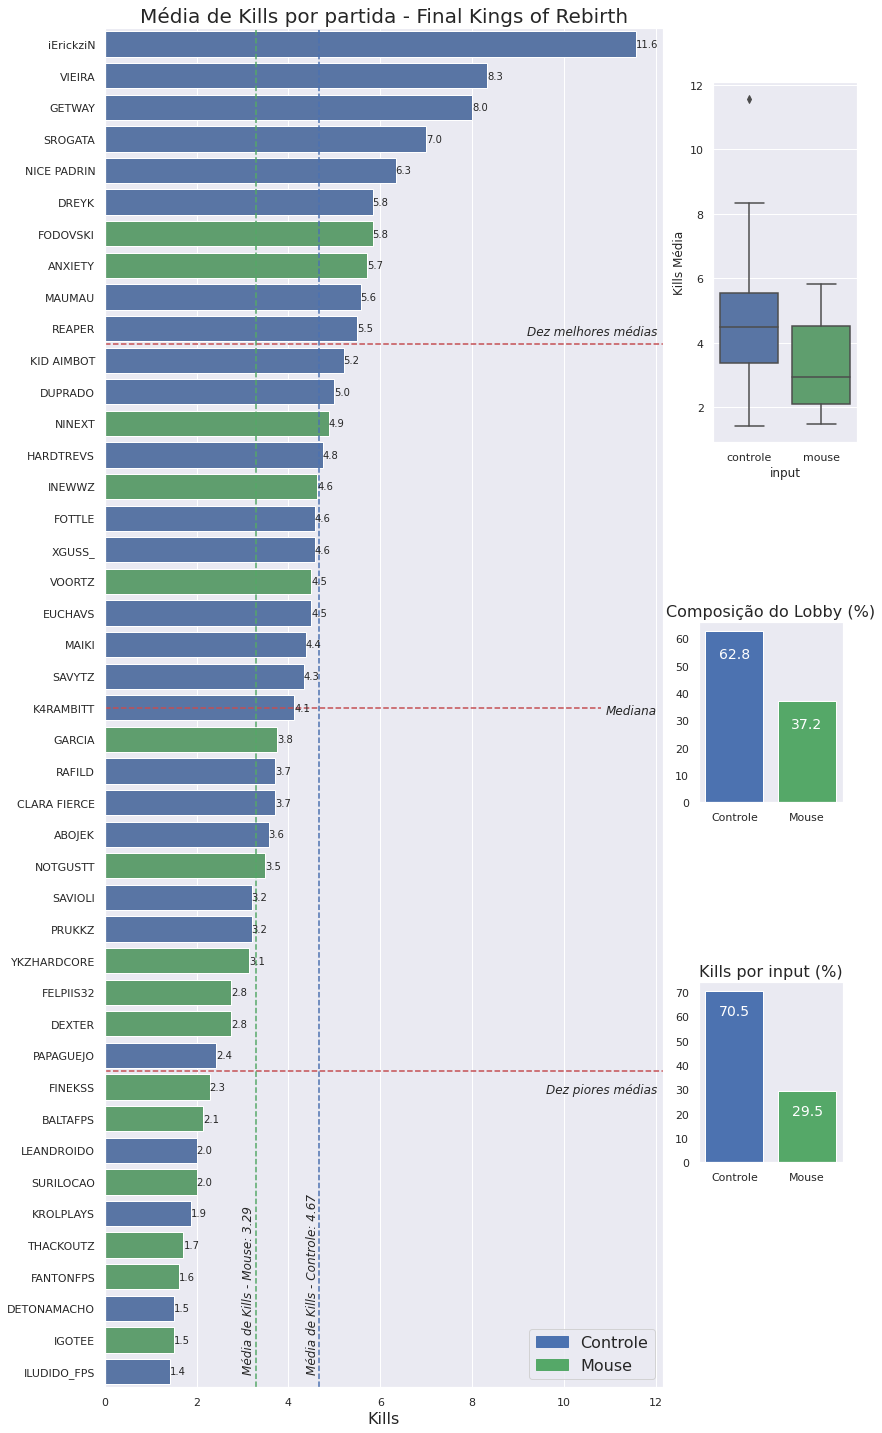

In [156]:
cores = ['b' if i == 'controle' else 'g' for i in players_kills_media_decrescente['input']]
sns.set(style="darkgrid")

fig, ax = plt.subplots(figsize=(10, 25))
plot = sns.barplot(data=players_kills_media_decrescente,
                   y='player', x='Kills Média',
                   palette=cores,
                   ax=ax,
                   orient = 'h'
                   )

for i in plot.patches:
  rotulo_dados = i.get_width().round(1)
  plot.annotate(rotulo_dados,
                (i.get_width(), i.get_y() + i.get_height() / 2),
                va='center', fontsize = 10)

plt.axhline(9.5, 0, 1, color='r', **{'ls': 'dashed'})
plt.axhline(32.5, 0, 1, color='r', **{'ls': 'dashed'})
plt.axhline(21, 0, 0.89, color='r', **{'ls': 'dashed'})
plt.axvline((players.query('input == "mouse"')['Kills Média'].mean()), 0, 1, color='g', **{'ls': 'dashed'})
plt.axvline((players.query('input == "controle"')['Kills Média'].mean()), 0, 1, color='b', **{'ls': 'dashed'})

controle = mpatches.Patch(color='b', label='Controle')
mouse = mpatches.Patch(color='g', label='Mouse')
plt.legend(handles=[controle, mouse], fontsize=16)

ax.set_title('Média de Kills por partida - Final Kings of Rebirth', fontsize=20)
ax.set_ylabel('')
ax.set_xlabel('Kills', fontsize=16)
ax.text(9.2, 9.2, 'Dez melhores médias', style='italic')
ax.text(10.9, 21.2, 'Mediana', style='italic')
ax.text(9.6, 33.2, 'Dez piores médias', style='italic')

media_kills_mouse = players.query('input == "mouse"')['Kills Média'].mean()-0.3
media_kills_controle = players.query('input == "controle"')['Kills Média'].mean()-0.3

ax.text(media_kills_mouse, 42, 'Média de Kills - Mouse: ' + str(media_kills_mouse.round(2)+0.3), style='italic', rotation=90)
ax.text(media_kills_controle, 42, 'Média de Kills - Controle: ' + str(media_kills_controle.round(2)+0.3), style='italic', rotation=90)

cores2 = ['b' if i == 'controle' else 'g' for i in dist_freq_input.index]

percentual_players = fig.add_axes([0.95, 0.45, 0.2, 0.1])
percentual_players.bar(dist_freq_input.index, dist_freq_input['Percentual de players (%)'], color=cores2, tick_label=['Controle', 'Mouse'])
percentual_players.grid(False)
percentual_players.set_title('Composição do Lobby (%)', fontsize=16)

for i in percentual_players.patches:
  rotulo_dados = i.get_height().round(1)
  percentual_players.annotate(rotulo_dados,
                (i.get_x() + i.get_width() / 2, i.get_height()-10),
                ha='center', fontsize = 14, color='white')

percentual_kills = fig.add_axes([0.95, 0.25, 0.2, 0.1])
percentual_kills.bar(dist_freq_input.index, dist_freq_input['Percentual de kills (%)'], color=cores2, tick_label=['Controle', 'Mouse'])
percentual_kills.grid(False)
percentual_kills.set_title('Kills por input (%)', fontsize=16)

for i in percentual_kills.patches:
  rotulo_dados = i.get_height().round(1)
  percentual_kills.annotate(rotulo_dados,
                (i.get_x() + i.get_width() / 2, i.get_height()-10),
                ha='center', fontsize = 14, color='white')

boxplot_kills = fig.add_axes([0.97, 0.65, 0.2, 0.2])
sns.boxplot(data=players, x='input', y='Kills Média', palette=['b', 'g'])

plt.show(plot)

In [28]:
players_colocacao_media_crescente = players.sort_values('Colocação Média', ascending = True)
players_colocacao_media_crescente['Posição Colocação Média'] = range(1, len(players) + 1)
players_colocacao_media_crescente.head()

,player,input,Kills Média,Colocação Média,Posição Colocação Média
12,MAUMAU,controle,5.571429,9.428571,1
28,NICE PADRIN,controle,6.333333,10.000000,2
5,VIEIRA,controle,8.333333,11.333333,3
23,GETWAY,controle,8.000000,13.250000,4
40,INEWWZ,mouse,4.625000,13.375000,5


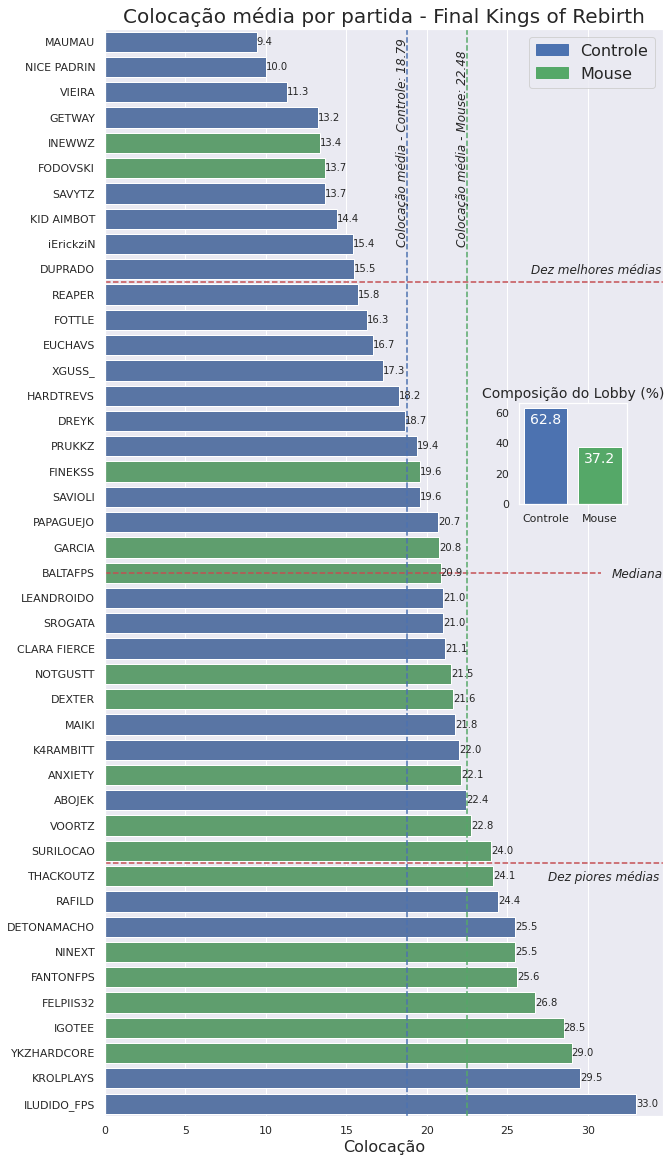

In [29]:
sns.set(style="darkgrid")

cores = ['b' if i == 'controle' else 'g' for i in players_colocacao_media_crescente['input']]

fig, ax = plt.subplots(figsize=(10, 20))
plot = sns.barplot(data=players_colocacao_media_crescente, y='player', x='Colocação Média', palette=cores, ax=ax, orient = 'h')

for i in plot.patches:
  rotulo_dados = i.get_width().round(1)
  plot.annotate(rotulo_dados,
                (i.get_width(), i.get_y() + i.get_height() / 2),
                va='center', fontsize = 10)

plt.axhline(9.5, 0, 1, color='r', **{'ls': 'dashed'})
plt.axhline(32.5, 0, 1, color='r', **{'ls': 'dashed'})
plt.axhline(21, 0, 0.89, color='r', **{'ls': 'dashed'})
plt.axvline((players.query('input == "mouse"')['Colocação Média'].mean()), 0, 1, color='g', **{'ls': 'dashed'})
plt.axvline((players.query('input == "controle"')['Colocação Média'].mean()), 0, 1, color='b', **{'ls': 'dashed'})

controle = mpatches.Patch(color='b', label='Controle')
mouse = mpatches.Patch(color='g', label='Mouse')
plt.legend(handles=[controle, mouse], fontsize=16)

ax.set_title('Colocação média por partida - Final Kings of Rebirth', fontsize=20)
ax.set_ylabel('')
ax.set_xlabel('Colocação', fontsize=16)
ax.text(26.5, 9.2, 'Dez melhores médias', style='italic')
ax.text(31.5, 21.2, 'Mediana', style='italic')
ax.text(27.5, 33.2, 'Dez piores médias', style='italic')

media_colocacao_mouse = players.query('input == "mouse"')['Colocação Média'].mean()-0.7
media_colocacao_controle = players.query('input == "controle"')['Colocação Média'].mean()-0.7

ax.text(media_colocacao_mouse, 8, 'Colocação média - Mouse: ' + str(media_colocacao_mouse.round(2)+0.7), style='italic', rotation=90)
ax.text(media_colocacao_controle, 8, 'Colocação média - Controle: ' + str(media_colocacao_controle.round(2)+0.7), style='italic', rotation=90)

cores2 = ['b' if i == 'controle' else 'g' for i in dist_freq_input.index]

percentual_players = fig.add_axes([0.70, 0.55, 0.15, 0.07])
percentual_players.bar(dist_freq_input.index, dist_freq_input['Percentual de players (%)'], color=cores2, tick_label=['Controle', 'Mouse'])
percentual_players.grid(False)
percentual_players.set_title('Composição do Lobby (%)', fontsize=14)

for i in percentual_players.patches:
  rotulo_dados = i.get_height().round(1)
  percentual_players.annotate(rotulo_dados,
                (i.get_x() + i.get_width() / 2, i.get_height()-10),
                ha='center', fontsize = 14, color='white')

plt.show(plot)

In [30]:
players['dif_colocacao_media_max'] = players['Colocação Média'].max()-players['Colocação Média']
players['indice_desempenho'] = players['dif_colocacao_media_max'] + players['Kills Média']
players = players.sort_values('indice_desempenho', ascending=False)
players.head()

,player,input,Kills Média,Colocação Média,dif_colocacao_media_max,indice_desempenho
5,VIEIRA,controle,8.333333,11.333333,21.666667,30.000000
28,NICE PADRIN,controle,6.333333,10.000000,23.000000,29.333333
12,MAUMAU,controle,5.571429,9.428571,23.571429,29.142857
6,iErickziN,controle,11.571429,15.428571,17.571429,29.142857
23,GETWAY,controle,8.000000,13.250000,19.750000,27.750000


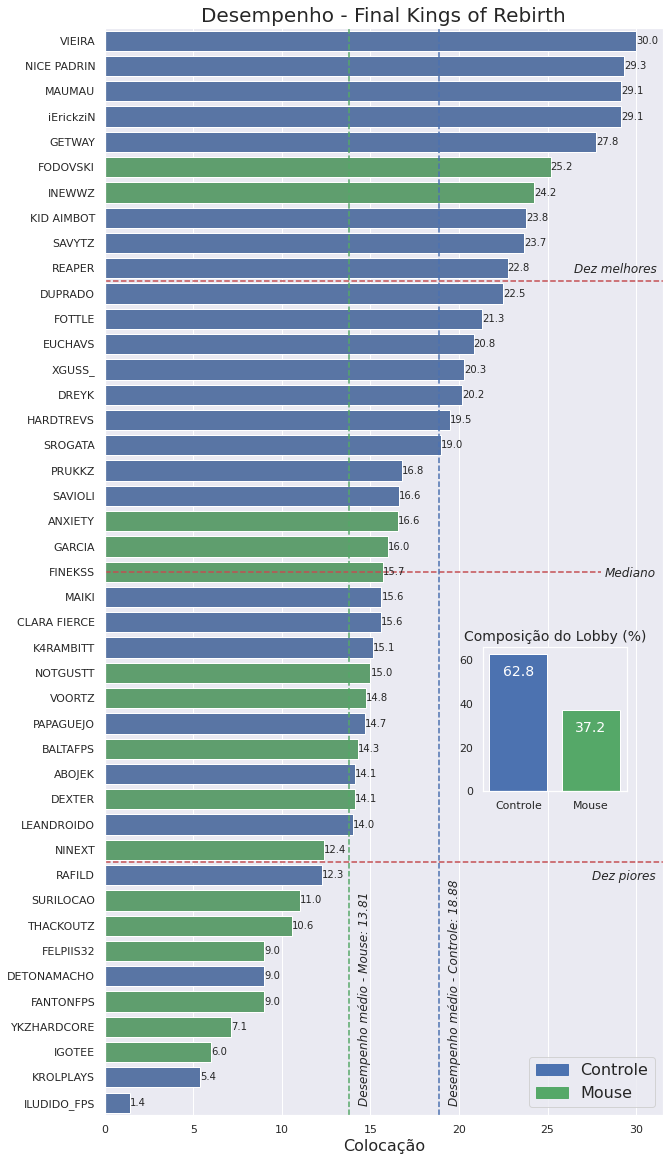

In [103]:
sns.set(style="darkgrid")

cores = ['b' if i == 'controle' else 'g' for i in players['input']]

fig, ax = plt.subplots(figsize=(10, 20))
plot = sns.barplot(data=players, y='player', x='indice_desempenho', palette=cores, ax=ax, orient = 'h')

for i in plot.patches:
  rotulo_dados = i.get_width().round(1)
  plot.annotate(rotulo_dados,
                (i.get_width(), i.get_y() + i.get_height() / 2),
                va='center', fontsize = 10)

plt.axhline(9.5, 0, 1, color='r', **{'ls': 'dashed'})
plt.axhline(32.5, 0, 1, color='r', **{'ls': 'dashed'})
plt.axhline(21, 0, 0.89, color='r', **{'ls': 'dashed'})
plt.axvline((players.query('input == "mouse"')['indice_desempenho'].mean()), 0, 1, color='g', **{'ls': 'dashed'})
plt.axvline((players.query('input == "controle"')['indice_desempenho'].mean()), 0, 1, color='b', **{'ls': 'dashed'})

controle = mpatches.Patch(color='b', label='Controle')
mouse = mpatches.Patch(color='g', label='Mouse')
plt.legend(handles=[controle, mouse], fontsize=16)

ax.set_title('Desempenho - Final Kings of Rebirth', fontsize=20)
ax.set_ylabel('')
ax.set_xlabel('Colocação', fontsize=16)
ax.text(26.5, 9.2, 'Dez melhores', style='italic')
ax.text(28.2, 21.2, 'Mediano', style='italic')
ax.text(27.5, 33.2, 'Dez piores', style='italic')

desempenho_medio_mouse = players.query('input == "mouse"')['indice_desempenho'].mean().round(2)
desempenho_medio_controle = players.query('input == "controle"')['indice_desempenho'].mean().round(2)

ax.text(desempenho_medio_mouse+0.5, 42, 'Desempenho médio - Mouse: ' + str(desempenho_medio_mouse), style='italic', rotation=90)
ax.text(desempenho_medio_controle+0.5, 42, 'Desempenho médio - Controle: ' + str(desempenho_medio_controle), style='italic', rotation=90)

cores2 = ['b' if i == 'controle' else 'g' for i in dist_freq_input.index]

percentual_players = fig.add_axes([0.65, 0.35, 0.2, 0.1])
percentual_players.bar(dist_freq_input.index, dist_freq_input['Percentual de players (%)'], color=cores2, tick_label=['Controle', 'Mouse'])
percentual_players.grid(False)
percentual_players.set_title('Composição do Lobby (%)', fontsize=14)

for i in percentual_players.patches:
  rotulo_dados = i.get_height().round(1)
  percentual_players.annotate(rotulo_dados,
                (i.get_x() + i.get_width() / 2, i.get_height()-10),
                ha='center', fontsize = 14, color='white')

plt.show(plot)

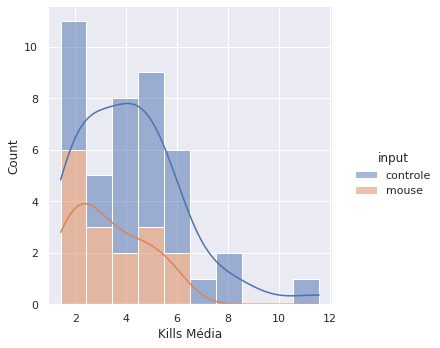

In [32]:
sns.displot(data=players, x='Kills Média', hue='input', multiple="stack", kde=True, bins=10)

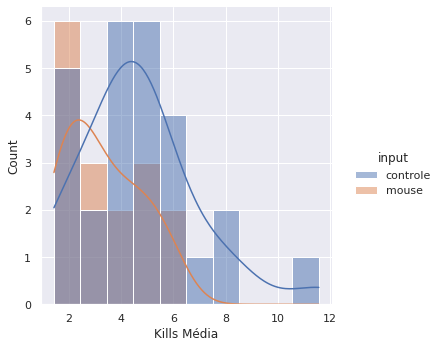

In [33]:
sns.displot(data=players, x='Kills Média', hue='input', kde=True, bins=10)

In [64]:
a = (players.query("input == 'controle'")['Kills Média'])
np.percentile(a, 52)

4.537142857142857

In [60]:
a = (players.query("input == 'mouse'")['Kills Média'])
np.percentile(a, 75)

4.53125

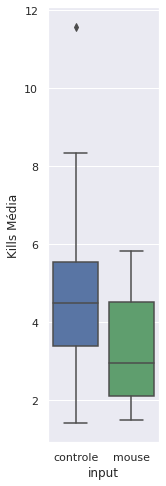

In [79]:
sns.set(style="darkgrid")

cores = ['b', 'g']

plt.subplots(figsize=(2, 8))
plot = sns.boxplot(data=players, x='input', y='Kills Média', palette=cores)

plt.show(plot)

- investigar quartis mouse (75%) e controle (50%)
- gráfico com sequenciamento de players por desempenho com destaque de input

In [35]:
import matplotlib.pyplot as plt

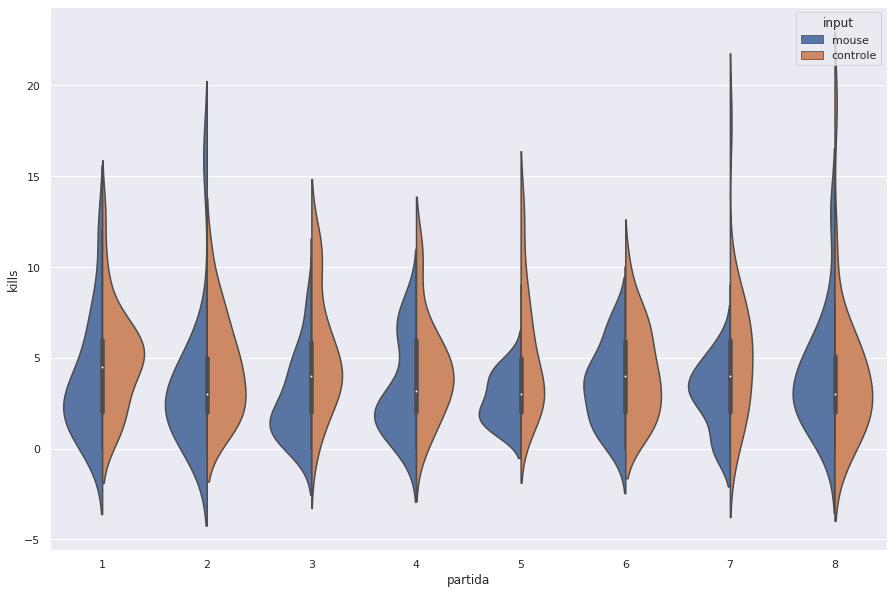

In [36]:
plt.figure(figsize=(15, 10))
sns.violinplot(x = 'partida', y = 'kills', hue = 'input', data = final_tratado, split = True)

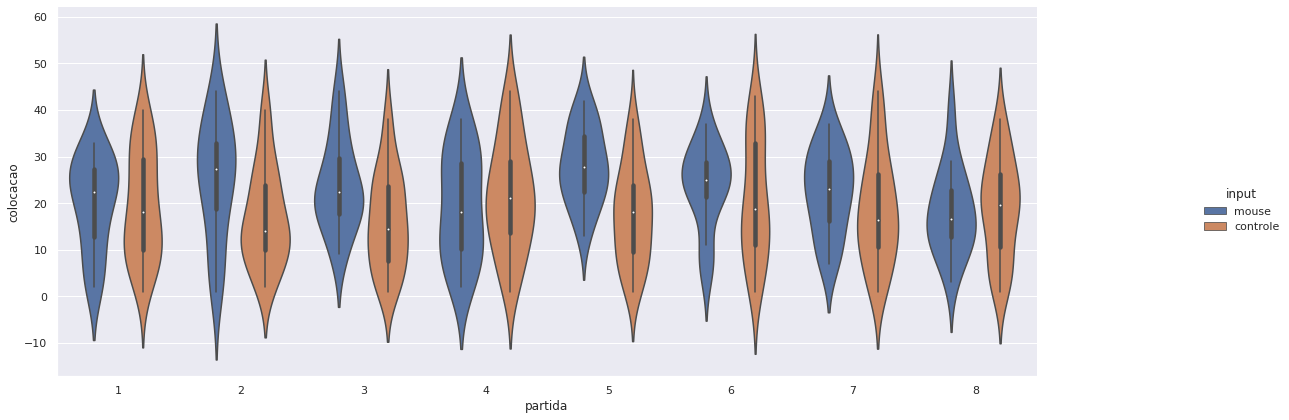

In [37]:
ax = sns.catplot(x = 'partida', y = 'colocacao', hue = 'input', data = final_tratado, kind="violin", height=6 , aspect=1)
ax.figure.set_size_inches(20, 6)
ax

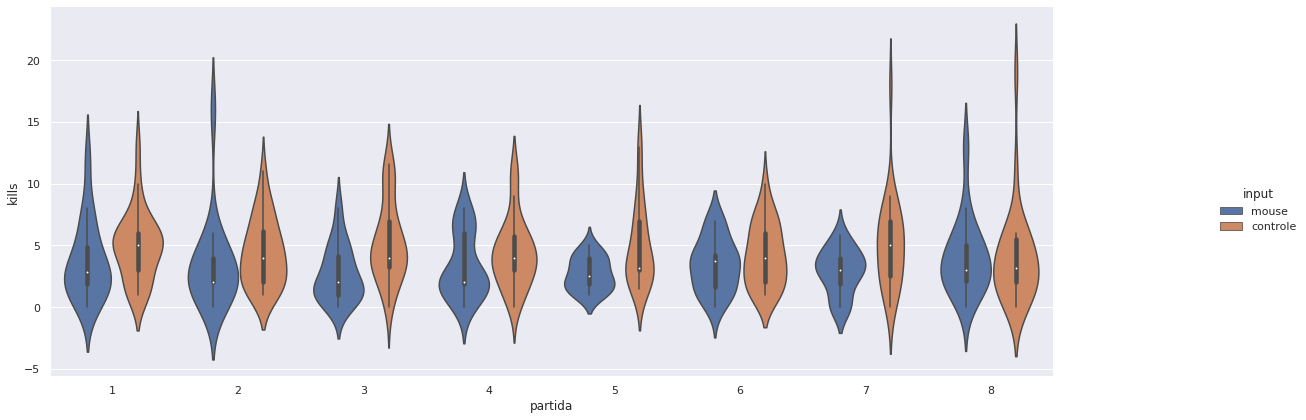

In [38]:
ax = sns.catplot(x = 'partida', y = 'kills', hue = 'input', data = final_tratado, kind="violin", height=6 , aspect=1)
ax.figure.set_size_inches(20, 6)
ax

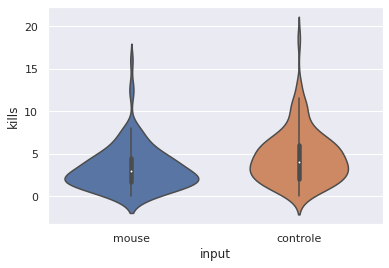

In [39]:
sns.violinplot(x = 'input', y = 'kills', data = final_tratado)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 6.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


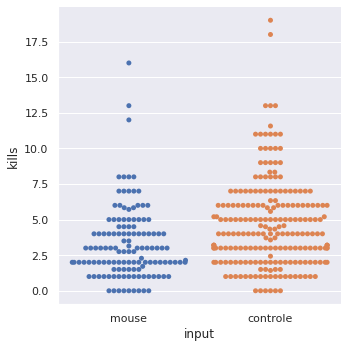

In [40]:
sns.catplot(x = 'input', y = 'kills', kind = 'swarm', data = final_tratado)

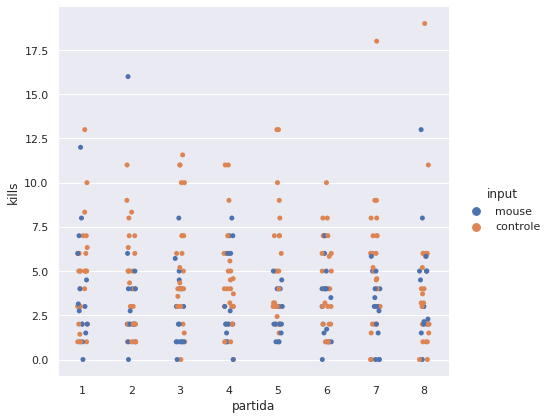

In [41]:
ax = sns.catplot(x = 'partida', y = 'kills', hue = 'input', data = final_tratado, height=6 , aspect=1)
ax.figure.set_size_inches(8, 6)
ax

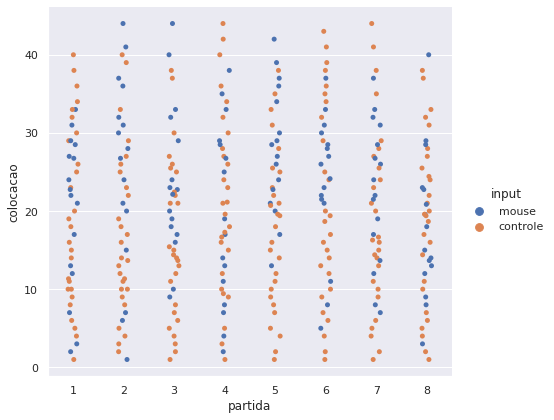

In [42]:
ax = sns.catplot(x = 'partida', y = 'colocacao', hue = 'input', data = final_tratado, height=6 , aspect=1)
ax.figure.set_size_inches(8, 6)
ax

In [43]:
final_tratado.groupby(by = 'input')[['kills', 'colocacao']].mean()

,kills,colocacao
input,,
controle,4.674118,18.791711
mouse,3.294271,22.484747


In [44]:
medias_players = final_tratado.groupby(['player', 'input'])[['kills', 'colocacao']].mean().sort_values(by = 'kills', ascending = False)
medias_players

,,kills,colocacao
player,input,,
iErickziN,controle,11.571429,15.428571
VIEIRA,controle,8.333333,11.333333
GETWAY,controle,8.000000,13.250000
SROGATA,controle,7.000000,21.000000
NICE PADRIN,controle,6.333333,10.000000
FODOVSKI,mouse,5.833333,13.666667
DREYK,controle,5.833333,18.666667
ANXIETY,mouse,5.714286,22.142857
MAUMAU,controle,5.571429,9.428571


In [45]:
medias_por_input = pd.DataFrame(medias_players.groupby(['input'])[['kills', 'colocacao']].mean().sort_values(by = 'kills', ascending = False))
medias_por_input

,kills,colocacao
input,,
controle,4.674118,18.791711
mouse,3.294271,22.484747


# Conclusões